#### 개요
* 데이터가 가장 많은 b-turbin을 이용해 처리

#### 라이브러리 불러오기

In [28]:
import os
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout, Conv2D

from model_evaluation import regression_evaluation
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#### 차트 한글설정

In [2]:
import platform

_os_name = platform.system()

# font_path는 사용할 폰트에 따라 변경하면 됨
_font_path = 'c:/Windows/Fonts/malgun.ttf' if _os_name=='Windows' \
    else '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
_font_family = fm.FontProperties(fname=_font_path).get_name()

# font 설정
plt.rcParams['font.family'] = _font_family

# 폰트캐시까지 삭제 후 한글폰트가 사용될 수 있도록 캐시 삭제
# --> 이렇게 해야 비로소 한글이 표현되는 경우가 많음
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [_font_family]

_fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, _fe)

#### 데이터 불러오기

In [3]:
_PATH_BASE = os.path.join(os.getcwd(), 'data', '41-turbin')
get_path = lambda turbin: os.path.join(_PATH_BASE, f'{turbin}_turbin.csv')

In [4]:
df_data = pd.read_csv(get_path('b'))

##### 하루 단위가 안되는 row 삭제

In [5]:
# 처음 2개와 마지막 4개
df_data = df_data.iloc[2:-4]

* 백업

In [6]:
df_data_back = df_data.copy()

#### 데이터 확인

##### 빠진로우 찾기

In [7]:
# 시간단위 데이터셋인데 시간단위가 빠진 로우가 있는지 확인
_datetime_fmt = '%Y-%m-%d %H:%M:%S'
_dt_start = df_data['TURBINE_TIME'].min()
_dt_end = df_data['TURBINE_TIME'].max()
dt_start = datetime.strptime(_dt_start, _datetime_fmt)
dt_end = datetime.strptime(_dt_end, _datetime_fmt)
_time_interval = timedelta(hours=1)
total_row_counts = int((dt_end - dt_start) / _time_interval) + 1

total_row_counts, df_data.shape

# (22320, (22320, 6))
# 다행이 시간단위로 모든 row가 존재함(NaN값(-1)은 존재)

(22320, (22320, 6))

#### 데이터 전처리

##### 결측치 처리

In [8]:
# 결측치 처리를 위해 목표컬럼인 'ACTIVE_POWER'값이 -1인 row의 풍향/풍속/발전량을 NaN으로 변경
# 참고로, 풍속과 발전량이 -1인 로우수가 같으니 발전량을 선택한것임(풍향은 -1이 나올수 있음)

# 풍속, 발전량은 음수가 올 수 없으므로 이렇게 NaN값 확인
non_value_counts = (df_data.drop('TURBINE_TIME', axis=1) < 0).sum()
non_value_counts

# 풍속과 발전량의 값이 음수(NaN)인 로우가 같음

WIND_SPEED       9353
WIND_DIR        15108
ACTIVE_POWER     9353
month               0
hour                0
dtype: int64

In [9]:
# 발전량이 음수인 컬럼의 풍향/풍속/발전량 값을 NaN으로 변경
target_col = 'ACTIVE_POWER'

df_data.loc[df_data[target_col] < 0, ['WIND_SPEED', 'WIND_DIR']+[target_col]] = np.nan

In [10]:
# 혹시 모르니 풍향이 음수인 경우 풍속과 발전량 값 확인
df_data[df_data['WIND_DIR']<0].head()

,TURBINE_TIME,WIND_SPEED,WIND_DIR,ACTIVE_POWER,month,hour
2,2020-01-16 00:00:00,4.355769,-1.425000,273.946154,1,0
3,2020-01-16 01:00:00,4.041667,-0.678333,214.488333,1,1
6,2020-01-16 04:00:00,6.335000,-1.238333,956.623333,1,4
8,2020-01-16 06:00:00,7.245000,-0.723333,1493.048333,1,6
9,2020-01-16 07:00:00,5.398333,-0.260000,628.846667,1,7


In [11]:
# 시계열성값을 이용한 결측치 처리
df_data = df_data.interpolate()

* 결측치 처리 결과 시각화

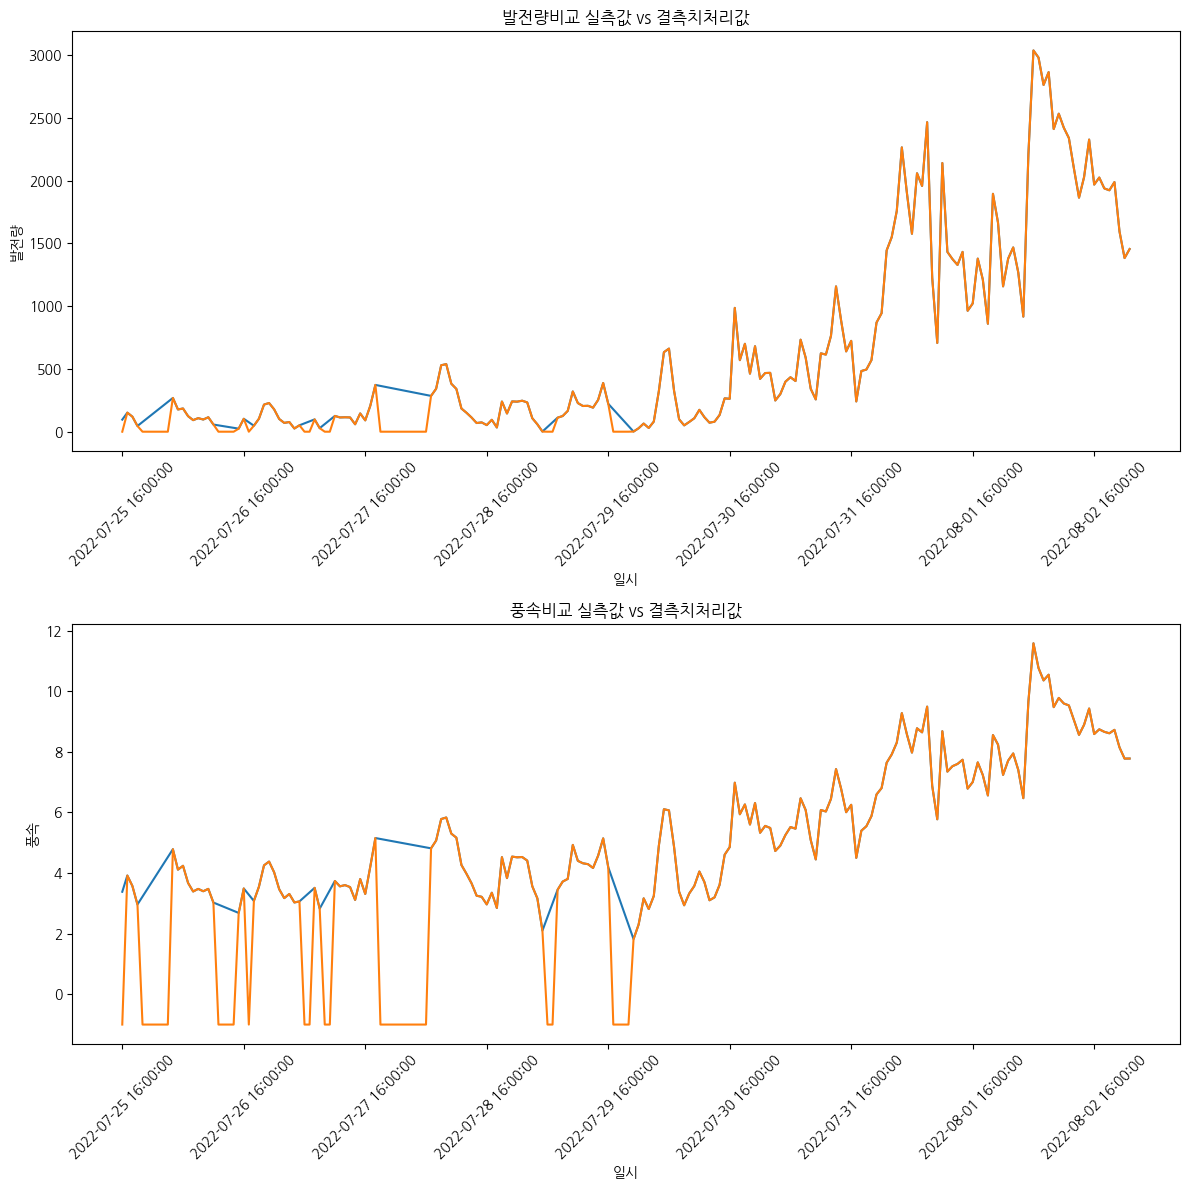

In [12]:
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.plot(df_data['TURBINE_TIME'][-200:], df_data[target_col][-200:])
plt.plot(df_data_back['TURBINE_TIME'][-200:], df_data_back[target_col][-200:])
plt.xlabel('일시')
plt.ylabel('발전량')
plt.xticks(df_data['TURBINE_TIME'][-200::24], rotation=45)
plt.title('발전량비교 실측값 vs 결측치처리값')

plt.subplot(2,1,2)
plt.plot(df_data['TURBINE_TIME'][-200:], df_data['WIND_SPEED'][-200:])
plt.plot(df_data_back['TURBINE_TIME'][-200:], df_data_back['WIND_SPEED'][-200:])
plt.xlabel('일시')
plt.ylabel('풍속')
plt.xticks(df_data['TURBINE_TIME'][-200::24], rotation=45)
plt.title('풍속비교 실측값 vs 결측치처리값')

plt.tight_layout()
plt.show()

# 풍속이 2이하면 발전량은 0이네

#### 시간데이터 컬럼 추가

In [13]:
df_data['TURBINE_TIME'] = pd.to_datetime(df_data['TURBINE_TIME'])
df_data['day'] = df_data['TURBINE_TIME'].dt.day
df_data['dayofyear'] = df_data['TURBINE_TIME'].dt.dayofyear

# 컬럼을 다 추가했으니 'TURBINE_TIME'을 인덱스로 변경
df_data = df_data.set_index('TURBINE_TIME')

#### 시험데이터 찾기

In [14]:
# 뒤에서부터 발전량이 처음으로 -1이 나오는 인덱스를 구해 그 이후 데이터를 시험데이터로 활용
start_test_idx = df_data_back[target_col][::-1][df_data_back[target_col][::-1]==-1].index[0]

# 원래값은 22222인데 앞에 2개 row을 지웠기에 22220, 전체는 6개 줄어듬
# 22320 - 22220 = 100개(시험데이터로 충분함)

#### 데이터 백업2

In [15]:
df_data_back2 = df_data.copy()

#### 모델링 1차

In [16]:
WINDOW_SIZE = 48

In [17]:
X_data = df_data.drop(target_col, axis=1)
y_data = df_data[target_col]

In [18]:
scaler = MinMaxScaler()
X_data_array = scaler.fit_transform(X_data)
y_data_array = y_data.values

In [19]:
X_data_win = []
y_data_win = []
for i in range(len(X_data_array) - WINDOW_SIZE):
    X_data_win.append(X_data_array[i:i+WINDOW_SIZE, :])
    y_data_win.append(y_data_array[i+WINDOW_SIZE])
X_data_win = np.array(X_data_win)
y_data_win = np.array(y_data_win)

In [20]:
# 시험데이터로 뒤에서 96개 추출(4일자 데이터 24*4)
X_train, X_test = X_data_win[:-96, :], X_data_win[-96:, :]
y_train, y_test = y_data_win[:-96], y_data_win[-96:]

In [33]:
X_train_f = np.mean(X_train, axis=1)
X_test_f = np.mean(X_test, axis=1)

In [34]:
model_xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    n_jobs=-1,
    max_depth=3,
    learning_rate=0.11,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=1234
).fit(X_train_f, y_train)

pred_xgb = model_xgb.predict(X_test_f)
_ = regression_evaluation(y_test, pred_xgb)

R2_SCORE: 0.166646, MAPE2: 46.266506, MSE: 545783.036113, RMSE: 738.771302, MAPE: 0.771107, MAE: 538.224875


In [35]:
for t, p in zip(y_test, pred_xgb):
    print(f'{t:>15.6}, {p:>15.6}')

        28.8316,         326.417
        79.5117,         326.417
        322.817,         326.417
        632.879,         326.417
        661.581,         326.417
        326.385,         358.871
        98.0356,         370.755
        49.4818,         370.755
        76.7065,          347.08
        106.125,          347.08
        173.251,          347.08
        114.736,         350.644
        70.7596,         350.644
          78.81,         350.644
        132.332,         350.644
        264.818,         350.644
        261.264,         350.644
        986.228,          381.25
        569.346,          381.25
        699.811,         427.069
        461.567,         377.078
        680.402,         377.078
        420.532,         393.773
        466.657,         400.108
        468.232,         400.108
         247.87,         400.108
        298.928,         400.108
          397.5,         400.108
        433.158,         387.806
        402.973,         387.806
        73

In [21]:
# model = tf.keras.Sequential([
#     Bidirectional(LSTM(units=50, activation='relu', return_sequences=True), input_shape=X_train.shape[1:]),
#     Bidirectional(LSTM(units=50, activation='relu')),
#     Dense(1)
# ])

# model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
# model.fit(X_train, y_train, epochs=10, batch_size=32)

In [23]:
# model_cnn = tf.keras.Sequential([
#     # 여기도 차원이 너무 적어 보통 (3,3)을 하는데 (1,1)로 사용
#     Conv2D(32, (1,1), activation='relu', input_shape=(X_train.shape[1:])),
#     # MaxPooling2D((2,2)),    # 입력데이터의 차원이 너무적어(13*1*1) 이 부분은 전부 생략함
#     Conv2D(64, (1,1), activation='relu'),
#     # MaxPooling2D((2,2)),
#     Conv2D(128, (1,1), activation='relu'),
#     # MaxPooling2D((2,2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])
# model_cnn.compile(
#     optimizer='adam',
#     loss='mean_squared_error',
#     metrics=['mae']
# )
# model_cnn.summary()

In [24]:
# model_cnn.fit(X_train, y_train, epochs=10, batch_size=32)

In [25]:
# pred_cnn = model_cnn.predict(X_test).reshape(-1)

In [26]:
# regression_evaluation(y_test, pred_cnn)

In [27]:
# for t, p in zip(y_test, pred):
#     print(f'{t:>15.6}, {p:>15.6}')